# Brain Tumor Detection and Classification (Ananth Kandala)
Data set: MRI images of brain tumors (https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256).
Aim: develop a CNN model to detect and classify images into four categories: [no tumor, glioma tumor, meningioma tumor and pituitary tumor]. 
The data is already classified into appropriate subfolders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

2024-03-23 12:01:26.459697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 12:01:26.459767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 12:01:26.460371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 12:01:26.465856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-23 12:01:35.101754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [3]:
plt.rcParams['figure.dpi'] = 100

### Data Directory

In [4]:
path = ''#path to the data set

### Load the images into tensorflow dataset
This code will load all images from all the subdirectories and label them (class = sub directory). It returns training and validation sets (0.9:0.1) in the tensorflow dataset format. Images are batched into size of 32 and resized to 224x224 (this is the input size for Xception)

In [5]:
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  class_names=['normal', 'glioma_tumor','meningioma_tumor','pituitary_tumor'],
  validation_split=0.1,
  subset="both",
  label_mode='categorical',
  color_mode='rgb',
  seed=32,
  batch_size=32,
  image_size=(224, 224),
  shuffle=True
  )

Found 3096 files belonging to 4 classes.
Using 2787 files for training.
Using 309 files for validation.


## Visualize images from each category

normal


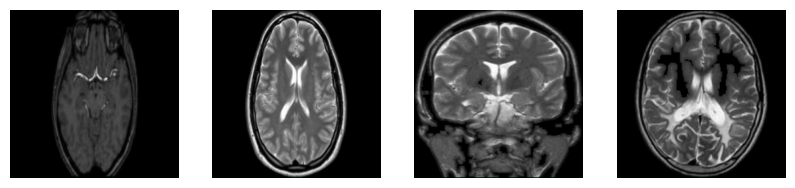

glioma_tumor


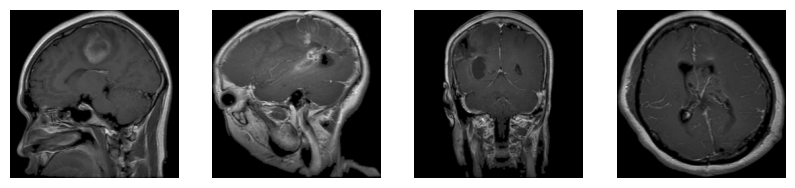

meningioma_tumor


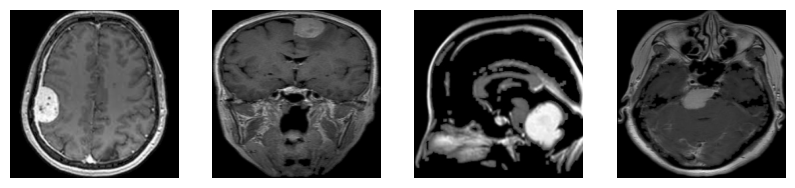

pituitary_tumor


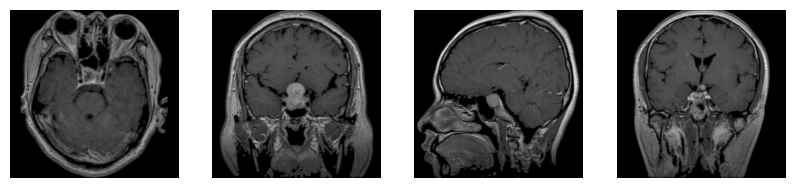

In [6]:
import os
class_names = train_ds.class_names
num_images_per_class = 4
for x in class_names:
    print(x)
    subpath = path + '/' + x
    files = os.listdir(subpath)
    indexes = np.random.randint(0, len(files), num_images_per_class)
    fig, ax = plt.subplots(1, num_images_per_class, figsize=(10, 10))
    for i, idx in enumerate(indexes):
        img = plt.imread(subpath + '/' + files[idx])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

#### We use a pretrained Xception model. 

In [7]:
def preprocess(image, label):
    # resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(image) 
    return final_image, label

In [8]:
training_ds = train_ds.map(preprocess).prefetch(1)
validation_ds = valid_ds.map(preprocess).prefetch(1)

## Define the Model
Load pretrained Xception weights and remove its top layers. We add a global average pooling layer and then a dense classification layer. We will train only the top 4 layers of the base model and the dense layer. Apply softmax at the end to obtain probability of each category.

In [9]:
n_classes = 4
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [10]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

### We also add an early stopping condition

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

### Optimizer
We use an adam optimizer with a low learning rate to avoid overly disturbing the pretrained layers.

In [12]:
# optimizer = tf.keras.optimizers.legacy.SGD(lr=0.001, momentum=0.9, decay=0.01)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(training_ds, epochs=100, validation_data=validation_ds, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/100


2024-03-23 12:01:42.753832: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-23 12:01:43.297746: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 294.49MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 12:01:43.298076: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 294.49MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 12:01:43.298116: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 294.49MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there co

88/88 [==============================] - 12s 86ms/step - loss: 1.2868 - accuracy: 0.3850 - val_loss: 1.1354 - val_accuracy: 0.5372
Epoch 2/100
88/88 [==============================] - 6s 64ms/step - loss: 1.1060 - accuracy: 0.5737 - val_loss: 1.0081 - val_accuracy: 0.6440
Epoch 3/100
88/88 [==============================] - 6s 64ms/step - loss: 0.9786 - accuracy: 0.6789 - val_loss: 0.9204 - val_accuracy: 0.6667
Epoch 4/100
88/88 [==============================] - 6s 64ms/step - loss: 0.8882 - accuracy: 0.7147 - val_loss: 0.8523 - val_accuracy: 0.7087
Epoch 5/100
88/88 [==============================] - 6s 64ms/step - loss: 0.8188 - accuracy: 0.7420 - val_loss: 0.7991 - val_accuracy: 0.7379
Epoch 6/100
88/88 [==============================] - 6s 65ms/step - loss: 0.7623 - accuracy: 0.7592 - val_loss: 0.7560 - val_accuracy: 0.7476
Epoch 7/100
88/88 [==============================] - 6s 64ms/step - loss: 0.7240 - accuracy: 0.7783 - val_loss: 0.7226 - val_accuracy: 0.7540
Epoch 8/100
88/88

## Visualize training/validation accuracy

In [13]:
frame = pd.DataFrame(history.history)
print(frame.columns)

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


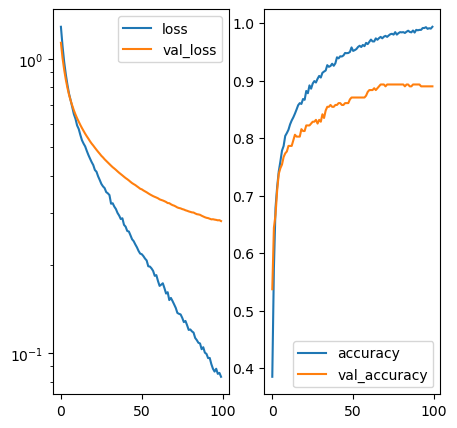

In [14]:
import matplotlib.pyplot as plt
fig, Ax = plt.subplots(figsize=(5, 5), ncols=2)
ax = Ax[0]
for col in ['loss', 'val_loss']:
    ax.plot(frame[col], label=col)
ax.set_yscale('log')
ax.legend(loc=0)
ax = Ax[1]
for col in ['accuracy', 'val_accuracy']:
    ax.plot(frame[col], label=col)
    # ax.set_yscale('log')
    ax.legend(loc=0)
plt.show()

Clearly, the model is over fitting and memorizing the training data after ~60 epochs of training.

### Print the best validation accuracy

In [19]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

10/10 [==============================] - 1s 54ms/step - loss: 0.2810 - accuracy: 0.8900
Validation Accuracy: 89.00%


### Final validation accuracy

In [20]:
#load best model
model = tf.keras.models.load_model('model.keras')

In [21]:
prediction = model.predict(validation_ds)
predicted_classes = np.argmax(prediction, axis=1)
# get labels from validation_ds
validation_labels = []
for images, labels in validation_ds:
    validation_labels.append(labels.numpy())
validation_labels = np.concatenate(validation_labels)
correct_labels = [np.argmax(i) for i in validation_labels]
print('Fraction of correctly classified images = ', np.sum(predicted_classes == correct_labels)/len(correct_labels))


10/10 [==============================] - 1s 71ms/step
Fraction of correctly classified images =  0.889967637540453


In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(correct_labels, predicted_classes)
print(cm)

[[31  0  1  0]
 [ 0 85  9  1]
 [ 0  6 79  9]
 [ 0  3  5 80]]
